In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
import yfinance as yf

df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
df = df[['Close']]

C:\Users\Marcos Simoneli\AppData\Local\Temp\ipykernel_36156\3896639056.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [25]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [ ]:
# Função para criar janelas de dados sequenciais
def create_dataset(data, time_step=90):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [27]:
# Dividir dados em treino e validação (80% treino, 20% validação)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # pegar os 60 passos anteriores

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [28]:
print(X_test)

[[0.88249205 0.84323625 0.83699108 ... 0.79248068 0.76774706 0.74658676]
 [0.84323625 0.83699108 0.82924042 ... 0.76774706 0.74658676 0.72363975]
 [0.83699108 0.82924042 0.84730688 ... 0.74658676 0.72363975 0.74859676]
 ...
 [0.86132516 0.85372152 0.8608183  ... 0.98065543 0.97456448 0.97146266]
 [0.85372152 0.8608183  0.8678589  ... 0.97456448 0.97146266 0.97202647]
 [0.8608183  0.8678589  0.88239028 ... 0.97146266 0.97202647 0.9744517 ]]


In [29]:
# Remodelar para LSTM [amostras, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam(learning_rate=0.001)', loss='mean_squared_error')

c:\Users\Marcos Simoneli\OneDrive\Documentos\Machine Learning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0181 - val_loss: 0.0015
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.3462e-04 - val_loss: 8.3067e-04
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2622e-04 - val_loss: 0.0011
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3935e-04 - val_loss: 0.0012
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3535e-04 - val_loss: 0.0015
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3678e-04 - val_loss: 0.0015
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.2143e-04 - val_loss: 0.0014
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.1796e-04 - val_loss: 0.0013
Epoch 9/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5956e-04 - val_loss: 0.0012
Epoch 10/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.1744e-04 - val_loss: 0.0036
Epoch 11/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.2913e-04 - val_loss: 9.8003e-04
Epoch 12/40
50/

In [32]:
# Métricas
mae = mean_absolute_error(real_prices, predictions)
rmse = np.sqrt(mean_squared_error(real_prices, predictions))
mape = mean_absolute_percentage_error(real_prices, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")

MAE: 3.7365
RMSE: 4.5557
MAPE: 2.3466%


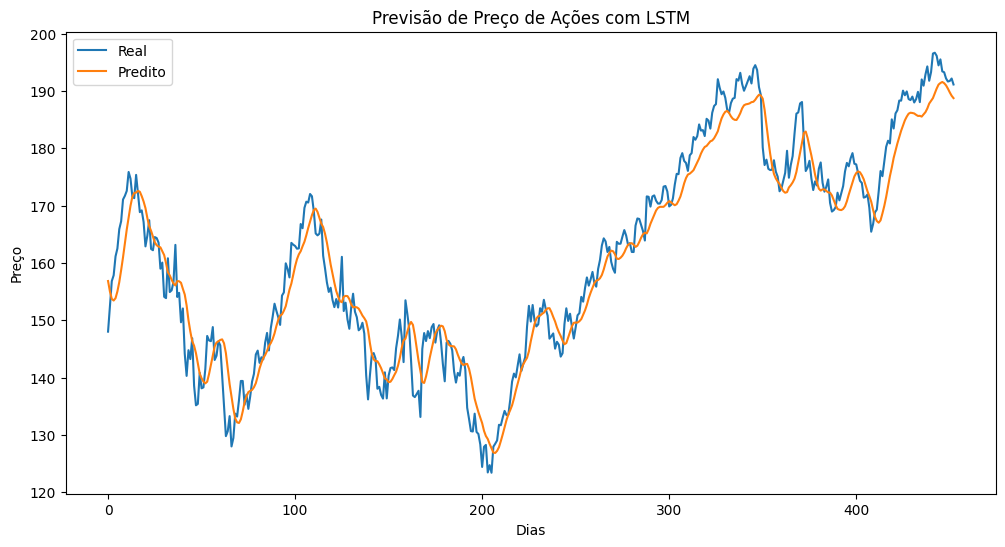

In [33]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Real')
plt.plot(predictions, label='Predito')
plt.title('Previsão de Preço de Ações com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.show()

print("")

model.save('modelo_lstm_acao.h5')